**Thinkful - 3.7.1 - Capstone - Predicting Student Performance**

In [7]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import warnings
import time
from sklearn.model_selection import cross_val_score
from sklearn import ensemble

# Display preferences.
#pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
warnings.filterwarnings(action="ignore",module="scipy",message="^internal gelsd")

# Grab and process the raw data.
df_raw = pd.read_csv('Data/2016 School Explorer_v2.csv', encoding='latin1')
print("Length = ",len(df_raw))
print(df_raw.isnull().sum())
df1 = df_raw.drop(['Adjusted Grade','New?','Other Location Code in LCGMS','School Name','Zip',
             'SED Code','Location Code','Address (Full)','Grade Low','Grade High','Grades',
                  'Latitude','Longitude'],axis=1)
df1.head()

Length =  1272
Adjusted Grade                                        1270
New?                                                  1245
Other Location Code in LCGMS                          1271
School Name                                              0
SED Code                                                 0
Location Code                                            0
District                                                 0
Latitude                                                 0
Longitude                                                0
Address (Full)                                           0
City                                                     0
Zip                                                      0
Grades                                                   0
Grade Low                                                0
Grade High                                               0
Community School?                                        0
Economic Need Index                      

,District,City,Community School?,Economic Need Index,School Income Estimate,Percent ELL,Percent Asian,Percent Black,Percent Hispanic,Percent Black / Hispanic,...,Grade 8 Math - All Students Tested,Grade 8 Math 4s - All Students,Grade 8 Math 4s - American Indian or Alaska Native,Grade 8 Math 4s - Black or African American,Grade 8 Math 4s - Hispanic or Latino,Grade 8 Math 4s - Asian or Pacific Islander,Grade 8 Math 4s - White,Grade 8 Math 4s - Multiracial,Grade 8 Math 4s - Limited English Proficient,Grade 8 Math 4s - Economically Disadvantaged
0,1,NEW YORK,Yes,0.919,31141.72,0.09,0.05,0.32,0.60,0.92,...,0,0,0,0,0,0,0,0,0,0
1,1,NEW YORK,No,0.641,56462.88,0.05,0.10,0.20,0.63,0.83,...,0,0,0,0,0,0,0,0,0,0
2,1,NEW YORK,No,0.744,44342.61,0.15,0.35,0.08,0.49,0.57,...,0,0,0,0,0,0,0,0,0,0
3,1,NEW YORK,No,0.860,31454.00,0.07,0.05,0.29,0.63,0.92,...,48,1,0,0,0,0,0,0,0,0
4,1,NEW YORK,No,0.730,46435.59,0.03,0.04,0.20,0.65,0.84,...,0,0,0,0,0,0,0,0,0,0


In [2]:
df1.dtypes

District                                                int64
City                                                   object
Community School?                                      object
Economic Need Index                                   float64
School Income Estimate                                float64
Percent ELL                                           float64
Percent Asian                                         float64
Percent Black                                         float64
Percent Hispanic                                      float64
Percent Black / Hispanic                              float64
Percent White                                         float64
Student Attendance Rate                               float64
Percent of Students Chronically Absent                float64
Rigorous Instruction %                                float64
Rigorous Instruction Rating                            object
Collaborative Teachers %                              float64
Collabor

In [3]:
df1 = df1.dropna()
print("Length = ",len(df1))
print(df1.isnull().sum())

Length =  795
District                                              0
City                                                  0
Community School?                                     0
Economic Need Index                                   0
School Income Estimate                                0
Percent ELL                                           0
Percent Asian                                         0
Percent Black                                         0
Percent Hispanic                                      0
Percent Black / Hispanic                              0
Percent White                                         0
Student Attendance Rate                               0
Percent of Students Chronically Absent                0
Rigorous Instruction %                                0
Rigorous Instruction Rating                           0
Collaborative Teachers %                              0
Collaborative Teachers Rating                         0
Supportive Environment %          

**Convert dataframe into two new dataframes**

In [4]:
# Dataframe which only contains categorical variables, which will be converted to dummies.
df = pd.get_dummies(df1, columns=['City','Community School?','Rigorous Instruction Rating',
                                         'Collaborative Teachers Rating','Supportive Environment Rating',
                                         'Effective School Leadership Rating','Strong Family-Community Ties Rating',
                                         'Trust Rating','Student Achievement Rating'],drop_first = True)
df.head()

,District,Economic Need Index,School Income Estimate,Percent ELL,Percent Asian,Percent Black,Percent Hispanic,Percent Black / Hispanic,Percent White,Student Attendance Rate,...,Effective School Leadership Rating_Not Meeting Target,Strong Family-Community Ties Rating_Exceeding Target,Strong Family-Community Ties Rating_Meeting Target,Strong Family-Community Ties Rating_Not Meeting Target,Trust Rating_Exceeding Target,Trust Rating_Meeting Target,Trust Rating_Not Meeting Target,Student Achievement Rating_Exceeding Target,Student Achievement Rating_Meeting Target,Student Achievement Rating_Not Meeting Target
0,1,0.919,31141.72,0.09,0.05,0.32,0.60,0.92,0.01,0.94,...,0,0,1,0,1,0,0,0,0,0
2,1,0.744,44342.61,0.15,0.35,0.08,0.49,0.57,0.04,0.94,...,1,0,0,0,0,0,1,0,0,0
3,1,0.860,31454.00,0.07,0.05,0.29,0.63,0.92,0.04,0.92,...,0,0,1,0,0,1,0,1,0,0
4,1,0.730,46435.59,0.03,0.04,0.20,0.65,0.84,0.10,0.93,...,0,0,1,0,0,1,0,0,1,0
5,1,0.858,39415.45,0.06,0.07,0.19,0.66,0.84,0.07,0.92,...,0,0,1,0,1,0,0,0,1,0


In [5]:
Y1 = df['Average ELA Proficiency']
Y2 = df['Average Math Proficiency']
X = df.drop(['Average ELA Proficiency','Average Math Proficiency'],axis=1)
print("Number of Features = ",len(df.columns))
df.head()

Number of Features =  205


,District,Economic Need Index,School Income Estimate,Percent ELL,Percent Asian,Percent Black,Percent Hispanic,Percent Black / Hispanic,Percent White,Student Attendance Rate,...,Effective School Leadership Rating_Not Meeting Target,Strong Family-Community Ties Rating_Exceeding Target,Strong Family-Community Ties Rating_Meeting Target,Strong Family-Community Ties Rating_Not Meeting Target,Trust Rating_Exceeding Target,Trust Rating_Meeting Target,Trust Rating_Not Meeting Target,Student Achievement Rating_Exceeding Target,Student Achievement Rating_Meeting Target,Student Achievement Rating_Not Meeting Target
0,1,0.919,31141.72,0.09,0.05,0.32,0.60,0.92,0.01,0.94,...,0,0,1,0,1,0,0,0,0,0
2,1,0.744,44342.61,0.15,0.35,0.08,0.49,0.57,0.04,0.94,...,1,0,0,0,0,0,1,0,0,0
3,1,0.860,31454.00,0.07,0.05,0.29,0.63,0.92,0.04,0.92,...,0,0,1,0,0,1,0,1,0,0
4,1,0.730,46435.59,0.03,0.04,0.20,0.65,0.84,0.10,0.93,...,0,0,1,0,0,1,0,0,1,0
5,1,0.858,39415.45,0.06,0.07,0.19,0.66,0.84,0.07,0.92,...,0,0,1,0,1,0,0,0,1,0


**Gradient Boost Regressor**

In [16]:
r_sqr_a = []
mean_cv_a = []
iteration = []
est_n = []
max_depth = []
loss = []
subsample = []
i = 1

start = time.time()

for n in range(1000, 5000, 1000):
    for m in range(1, 5):
        for s in range(2,10,2):
            s2 = s*0.1
            params = {'n_estimators': n,
                      'max_depth': m,
                      'loss': 'ls',
                      'subsample':s2}

            clf = ensemble.GradientBoostingRegressor(**params)
            clf.fit(X,Y1)

            r_sqr = clf.score(X, Y1)
            score = cross_val_score(clf, X, Y1, cv=10)
            mean_cv = score.mean()

            r_sqr_a.append(r_sqr)
            mean_cv_a.append(mean_cv)
            est_n.append(n)
            max_depth.append(m)
            loss.append('ls')
            subsample.append(s2)
            iteration.append(i)
            i += 1

stop = time.time()
a = stop - start
print("Run time = ",a)

Run time =  7346.4070789813995


In [20]:
df_CLF = pd.DataFrame(r_sqr_a,columns=['R-squared'])
df_CLF['Mean CV'] = pd.Series(mean_cv_a, index=df_CLF.index)
df_CLF['Estimators'] = pd.Series(est_n, index=df_CLF.index)
df_CLF['Max Depth'] = pd.Series(max_depth, index=df_CLF.index)
df_CLF['Loss Type'] = pd.Series(loss, index=df_CLF.index)
df_CLF['Subsample'] = pd.Series(subsample, index=df_CLF.index)
df_CLF['Iteration'] = pd.Series(iteration, index=df_CLF.index)

df_CLF.head()

,R-squared,Mean CV,Estimators,Max Depth,Loss Type,Subsample,Iteration
0,0.960051,0.793019,1000,1,ls,0.2,1
1,0.964307,0.812539,1000,1,ls,0.4,2
2,0.964449,0.812110,1000,1,ls,0.6,3
3,0.963003,0.809686,1000,1,ls,0.8,4
4,0.990441,0.805861,1000,2,ls,0.2,5


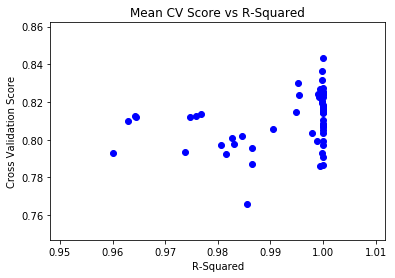

In [21]:
# Look at our data.
plt.scatter(r_sqr_a,mean_cv_a,color='blue')
plt.title('Mean CV Score vs R-Squared')
plt.xlabel('R-Squared')
plt.ylabel('Cross Validation Score')
plt.show()

In [22]:
df_CLF.loc[df_CLF['Mean CV'].idxmax()]

R-squared     0.999996
Mean CV       0.843217
Estimators        2000
Max Depth            3
Loss Type           ls
Subsample          0.4
Iteration           26
Name: 25, dtype: object


R-squared:
0.999996909173
[ 0.88810314  0.75206817  0.76005945  0.87620745  0.78272896  0.8801431
  0.87398888  0.85050155  0.85775396  0.49881175]
Weighted Accuracy: 0.80 (+/- 0.22)


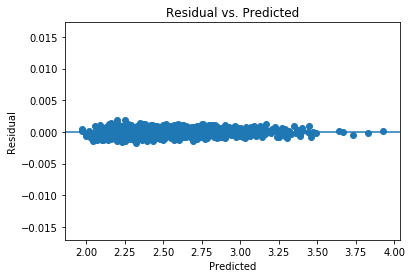

In [24]:
params = {'n_estimators': 2000,'max_depth': 3,'loss': 'ls','subsample':0.4}
clf = ensemble.GradientBoostingRegressor(**params)
clf.fit(X,Y1)

#Inspect results
print('\nR-squared:')
print(clf.score(X, Y1))
score_w = cross_val_score(clf, X, Y1, cv=10)
print(score_w)
print("Weighted Accuracy: %0.2f (+/- %0.2f)" % (score_w.mean(), score_w.std() * 2))

# Extract predicted values.
predict_clf = clf.predict(X)
resid_clf = Y1 - predict_clf

df['CLF Predict'] = pd.Series(predict_clf, index=df.index)
df['CLF Resid'] = pd.Series(resid_clf, index=df.index)
plt.scatter(predict_clf, resid_clf)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

In [66]:
feat_importances = pd.Series(clf.feature_importances_, index=X.columns)
feat_importances = feat_importances.nlargest(20)
print(feat_importances)

School Income Estimate                    0.052744
Economic Need Index                       0.039003
Percent Hispanic                          0.036653
Percent Black                             0.032527
Percent of Students Chronically Absent    0.027569
District                                  0.027275
Percent ELL                               0.025765
Strong Family-Community Ties %            0.023945
Effective School Leadership %             0.023347
Rigorous Instruction %                    0.023284
Grade 3 Math - All Students tested        0.022784
Grade 3 Math 4s - All Students            0.020947
Grade 4 Math - All Students Tested        0.020927
Percent White                             0.020908
Supportive Environment %                  0.020652
Grade 5 ELA - All Students Tested         0.019726
Grade 3 ELA - All Students Tested         0.019562
Grade 5 Math - All Students Tested        0.019512
Grade 4 ELA - All Students Tested         0.019354
Trust %                        

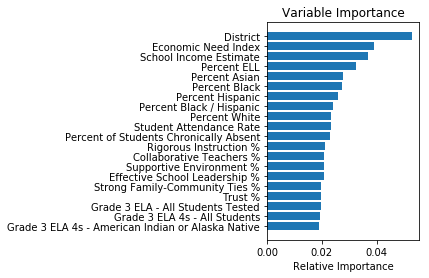

In [67]:
sorted_idx = np.argsort(feat_importances)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feat_importances[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

,School Income Estimate,Economic Need Index,Percent Hispanic,Percent Black,Percent of Students Chronically Absent,District,Percent ELL,Strong Family-Community Ties %,Effective School Leadership %,Rigorous Instruction %,Grade 3 Math - All Students tested,Grade 3 Math 4s - All Students,Grade 4 Math - All Students Tested,Percent White,Supportive Environment %,Grade 5 ELA - All Students Tested,Grade 3 ELA - All Students Tested,Grade 5 Math - All Students Tested,Grade 4 ELA - All Students Tested,Trust %
School Income Estimate,1.000000,-0.891388,-0.495459,-0.278477,-0.519645,0.234423,-0.347597,0.334662,0.174684,0.224357,0.110494,0.411133,0.106264,0.707366,0.336987,0.095860,0.117815,0.085632,0.113100,0.150860
Economic Need Index,-0.891388,1.000000,0.563402,0.319228,0.618113,-0.250186,0.408446,-0.326378,-0.229820,-0.259403,-0.105588,-0.502739,-0.100084,-0.779731,-0.358539,-0.102656,-0.113813,-0.090940,-0.107518,-0.185525
Percent Hispanic,-0.495459,0.563402,1.000000,-0.385474,0.230297,-0.285806,0.533479,-0.181497,-0.136290,-0.131536,0.066471,-0.327270,0.074046,-0.382532,-0.096226,0.065978,0.062704,0.075262,0.068497,-0.063638
Percent Black,-0.278477,0.319228,-0.385474,1.000000,0.406000,-0.039532,-0.443366,0.043827,-0.120659,-0.175310,-0.349659,-0.362275,-0.344208,-0.492595,-0.401268,-0.337920,-0.344833,-0.341681,-0.339585,-0.179427
Percent of Students Chronically Absent,-0.519645,0.618113,0.230297,0.406000,1.000000,-0.227206,-0.026706,-0.125811,-0.212225,-0.117590,-0.250046,-0.416238,-0.259921,-0.439335,-0.277986,-0.251405,-0.251278,-0.247601,-0.261009,-0.194406
District,0.234423,-0.250186,-0.285806,-0.039532,-0.227206,1.000000,-0.011505,-0.236569,-0.023670,0.065926,0.251580,0.138911,0.243718,0.156287,0.112479,0.253938,0.255003,0.250655,0.247074,0.014616
Percent ELL,-0.347597,0.408446,0.533479,-0.443366,-0.026706,-0.011505,1.000000,-0.307816,-0.127120,-0.123412,0.408215,0.045196,0.406647,-0.241516,0.060667,0.379650,0.390867,0.395852,0.392922,-0.048124
Strong Family-Community Ties %,0.334662,-0.326378,-0.181497,0.043827,-0.125811,-0.236569,-0.307816,1.000000,0.445064,0.272882,-0.263396,0.102716,-0.275758,0.252141,0.304628,-0.301420,-0.257147,-0.305938,-0.271780,0.414294
Effective School Leadership %,0.174684,-0.229820,-0.136290,-0.120659,-0.212225,-0.023670,-0.127120,0.445064,1.000000,0.597544,-0.068092,0.194710,-0.067944,0.210057,0.513870,-0.082134,-0.066634,-0.082921,-0.066551,0.878539
Rigorous Instruction %,0.224357,-0.259403,-0.131536,-0.175310,-0.117590,0.065926,-0.123412,0.272882,0.597544,1.000000,-0.039555,0.182970,-0.024697,0.266300,0.615019,-0.047592,-0.037962,-0.047203,-0.024175,0.534260


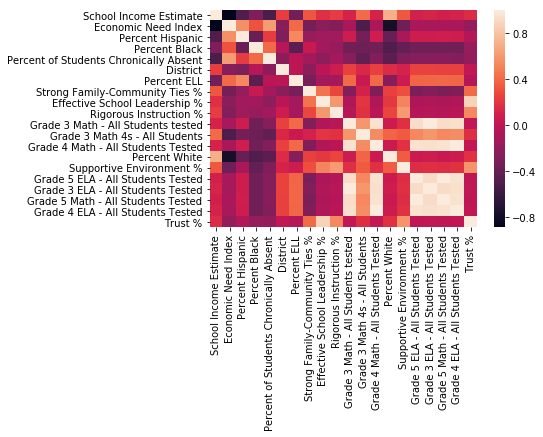

In [69]:
mtx = df[['School Income Estimate','Economic Need Index','Percent Hispanic','Percent Black',
     'Percent of Students Chronically Absent','District','Percent ELL','Strong Family-Community Ties %',
     'Effective School Leadership %','Rigorous Instruction %','Grade 3 Math - All Students tested',
     'Grade 3 Math 4s - All Students','Grade 4 Math - All Students Tested','Percent White','Supportive Environment %',
     'Grade 5 ELA - All Students Tested','Grade 3 ELA - All Students Tested','Grade 5 Math - All Students Tested',
     'Grade 4 ELA - All Students Tested','Trust %']]

sns.heatmap(mtx.corr())
correlation_matrix = mtx.corr()
display(correlation_matrix)


R-squared:
0.999953187638
[ 0.80681046  0.58943489  0.61416448  0.79885472  0.67384774  0.83728518
  0.76797667  0.73947193  0.79743116  0.06312328]
Weighted Accuracy: 0.67 (+/- 0.43)


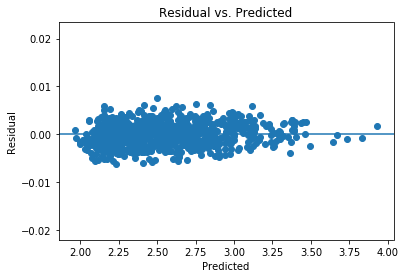

In [8]:
X = df[['School Income Estimate','Economic Need Index','Percent Hispanic','Percent Black',
     'Percent of Students Chronically Absent','District','Percent ELL','Strong Family-Community Ties %',
     'Effective School Leadership %','Rigorous Instruction %','Grade 3 Math - All Students tested',
     'Grade 3 Math 4s - All Students','Grade 4 Math - All Students Tested','Percent White','Supportive Environment %',
     'Grade 5 ELA - All Students Tested','Grade 3 ELA - All Students Tested','Grade 5 Math - All Students Tested',
     'Grade 4 ELA - All Students Tested','Trust %']]

params = {'n_estimators': 2000,'max_depth': 3,'loss': 'ls','subsample':0.4}
clf = ensemble.GradientBoostingRegressor(**params)
clf.fit(X,Y1)

#Inspect results
print('\nR-squared:')
print(clf.score(X, Y1))
score_w = cross_val_score(clf, X, Y1, cv=10)
print(score_w)
print("Weighted Accuracy: %0.2f (+/- %0.2f)" % (score_w.mean(), score_w.std() * 2))

# Extract predicted values.
predict_clf = clf.predict(X)
resid_clf = Y1 - predict_clf

df['CLF Predict'] = pd.Series(predict_clf, index=df.index)
df['CLF Resid'] = pd.Series(resid_clf, index=df.index)
plt.scatter(predict_clf, resid_clf)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()


R-squared:
0.970594307334
[ 0.898265    0.77820395  0.74452161  0.89505601  0.83090963  0.89634229
  0.88498311  0.86156711  0.85502429  0.49012657]
Weighted Accuracy: 0.81 (+/- 0.24)


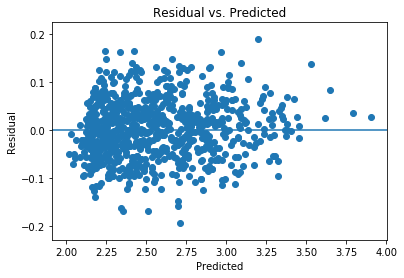

In [7]:
clf.fit(X,Y1)

#Inspect results
print('\nR-squared:')
print(clf.score(X, Y1))
score_w = cross_val_score(clf, X, Y1, cv=10)
print(score_w)
print("Weighted Accuracy: %0.2f (+/- %0.2f)" % (score_w.mean(), score_w.std() * 2))

# Extract predicted values.
predict_clf = clf.predict(X)
resid_clf = Y1 - predict_clf

df['CLF Predict'] = pd.Series(predict_clf, index=df.index)
df['CLF Resid'] = pd.Series(resid_clf, index=df.index)
plt.scatter(predict_clf, resid_clf)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

**Weighted KNN Regression**

R-squared:  0.62156140045
[ 0.56614976  0.065656    0.02659194  0.53066209  0.16096107  0.00147327
 -0.12526445 -0.73249898  0.2673394  -1.28227327]
Weighted Accuracy: -0.05 (+/- 1.07)


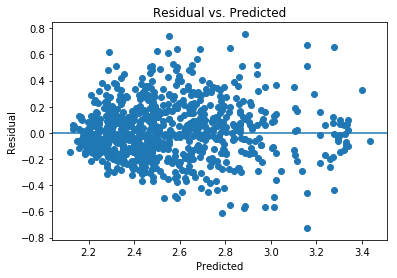

In [12]:
from sklearn import neighbors
# Run the same model, this time with weights.
#knn_w = neighbors.KNeighborsRegressor(n_neighbors=3, weights='distance')
knn_w = neighbors.KNeighborsRegressor(n_neighbors=4)
knn_w.fit(X,Y1)

#Inspect results
print("R-squared: ",knn_w.score(X,Y1))
score_w = cross_val_score(knn_w, X, Y1, cv=10)
print(score_w)
print("Weighted Accuracy: %0.2f (+/- %0.2f)" % (score_w.mean(), score_w.std() * 2))

# Extract predicted values.
predict_knn = knn_w.predict(X)
resid_knn = Y1 - predict_knn

df['KNN Predict'] = pd.Series(predict_knn, index=df.index)
df['KNN Resid'] = pd.Series(resid_knn, index=df.index)
plt.scatter(predict_knn, resid_knn)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

**Linear Regression**


R-squared:
0.839210048678
[ 0.84200978  0.62585123  0.64567601  0.83286934  0.71787099  0.85107081
  0.73938446  0.82071715  0.824339   -0.39889788]
Weighted Accuracy: 0.65 (+/- 0.72)


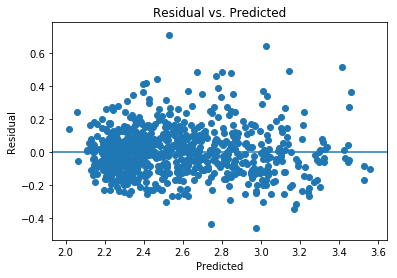

In [14]:
from sklearn import linear_model

# Instantiate and fit our model.
regr = linear_model.LinearRegression()
regr.fit(X, Y1)

# Inspect the results.
print('\nR-squared:')
print(regr.score(X, Y1))

# Extract predicted values.
predicted = regr.predict(X).ravel()
actual = Y1

# Calculate the error, also called the residual.
residual = actual - predicted

df['Predicted'] = pd.Series(predicted, index=df.index)
df['Residual'] = pd.Series(residual, index=df.index)

#Inspect results
score_w = cross_val_score(regr, X, Y1, cv=10)
print(score_w)
print("Weighted Accuracy: %0.2f (+/- %0.2f)" % (score_w.mean(), score_w.std() * 2))

# Extract predicted values.
predict_regr = regr.predict(X)
resid_regr = Y1 - predict_regr

df['Regr Predict'] = pd.Series(predict_regr, index=df.index)
df['Regr Resid'] = pd.Series(resid_regr, index=df.index)
plt.scatter(predict_regr, resid_regr)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

**Support Vector Machines**


R-squared:
0.925624514969
[ -2.67987476e-01  -1.55889626e+00  -1.73751647e+00  -6.78525107e-02
  -3.89444485e-01  -3.81087618e-02  -7.42641291e-01  -1.00619803e-02
  -5.67920399e-04  -3.67668004e-02]
Weighted Accuracy: -0.48 (+/- 1.25)


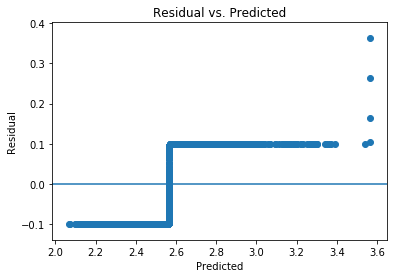

In [15]:
from sklearn.svm import SVR
svr = SVR()
svr.fit(X,Y1)

#Inspect results
print('\nR-squared:')
print(svr.score(X, Y1))
score_w = cross_val_score(svr, X, Y1, cv=10)
print(score_w)
print("Weighted Accuracy: %0.2f (+/- %0.2f)" % (score_w.mean(), score_w.std() * 2))

# Extract predicted values.
predict_svr = svr.predict(X)
resid_svr = Y1 - predict_svr

df['SVR Predict'] = pd.Series(predict_svr, index=df.index)
df['SVR Resid'] = pd.Series(resid_svr, index=df.index)
plt.scatter(predict_svr, resid_svr)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

In [ ]:
# Dataframe which contains objects that will need to be converted to floats
df_convert = df[['School Income Estimate','Percent ELL','Percent Black','Percent Hispanic',
                'Percent Black / Hispanic','Percent White','Student Attendance Rate','Percent Asian',
                'Percent of Students Chronically Absent','Rigorous Instruction %','Collaborative Teachers %',
                'Supportive Environment %','Effective School Leadership %','Strong Family-Community Ties %',
                'Trust %']]

for i in df_convert:
    for x in range(len(df_convert[i])):
        x = str(x)
        x = x.replace('$', '')
        x = x.replace(',', '')
    
for i in df_convert:
    pd.to_numeric(df_convert[i])
    
df_dummies.dtypes

#df3 = []
for i in df:
    if df[i].dtype == 'object':
        #df2 = df[i].map(lambda x: ''.join(list(filter(str.isdigit, x.strip('%')))))
        #df3 = df.apply(lambda x: ''.join(list(filter(str.isdigit, str(x))))))
        #df.apply(lambda x: ''.join(list(filter(str.isdigit, str(x)))))
        for x in range(len(df[i])):
            x = str(x)
            x = x.replace('$', '')
            x = x.replace(',', '')
            x = x.replace('%', '')
            if x.isdigit():
            #np.fromstring(df[i].values.astype('|S7').tobytes().replace(b'%',b''), dtype='|S6')
           # df[i].map(lambda x: x.strip('%'))
            #removed = original.replace("M", "")
                
        #print(i)

        #for j in df[i]:
         #   df[i][j] = df[i][j].replace("%", "")
#df = pd.get_dummies(df,drop_first=True)
#pd.to_numeric(df, errors='coerce')
#pd.to_numeric(df[i])

#df = df.fillna('')
#print("Length = ",len(df))
#df['Percent ELL'].astype('int64')
#print(df.dtypes)

df_objects = []
for i in df:
    if df[i].dtype == 'object':
        df[i] = pd.Series(df[i], index=df_objects.index)
        df = df.drop(df[i])

print(df.head())
print(df_objects.head())

df.dtypes
#print(len(df.columns))
df.head()

df = df.dropna()
for i in df:
    pd.to_numeric(df[i])
    print(i)
#pd.to_numeric(df)
#print(df.iloc[:,20])
print(list(df))

'''df2 = df1[['City','Community School?','Rigorous Instruction Rating','Collaborative Teachers Rating',
                 'Supportive Environment Rating','Effective School Leadership Rating',
                 'Strong Family-Community Ties Rating','Trust Rating','Student Achievement Rating']]'''

# Main dataframe, which only contains integers and floats

df3 = df1.drop(['City','Community School?','Rigorous Instruction Rating','Collaborative Teachers Rating',
                 'Supportive Environment Rating','Effective School Leadership Rating',
                 'Strong Family-Community Ties Rating','Trust Rating','Student Achievement Rating'],axis=1)
df3.head()

feature_importance = clf.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
print(feature_importance)
#feat_importances.iloc[:,'Feature Name']
#purchases.loc[:, 'country']
#print(feat_importances)
#print(feat_importances.sum())

feat_importances.set_axis(['Feature Name','Importance'], axis=1)
purchases.loc[:, 'country']
#feat_importances['Feature Name']
#feat_importances.columns
#most_important = feat_importances['Feature name']
#print(most_important)
print(feat_importances['Feature Name'])